In [ ]:
%pip install wordcloud # Installation de wordcloud permettant de générer des nuages de mots 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 566.6 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to /home/good-
[nltk_data]     boy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/good-
[nltk_data]     boy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/good-boy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/good-boy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dimensions du dataset: (31962, 3)

Aperçu des premières lignes:
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

Distribution des classes:
label
0    29720
1     2242
Name: count, dtype: int64
Logistic Regression Accuracy: 0.9510
Multinomial NB Accuracy: 0.9498
SVM Accuracy: 0.9571
VADER Accuracy: 0.7957


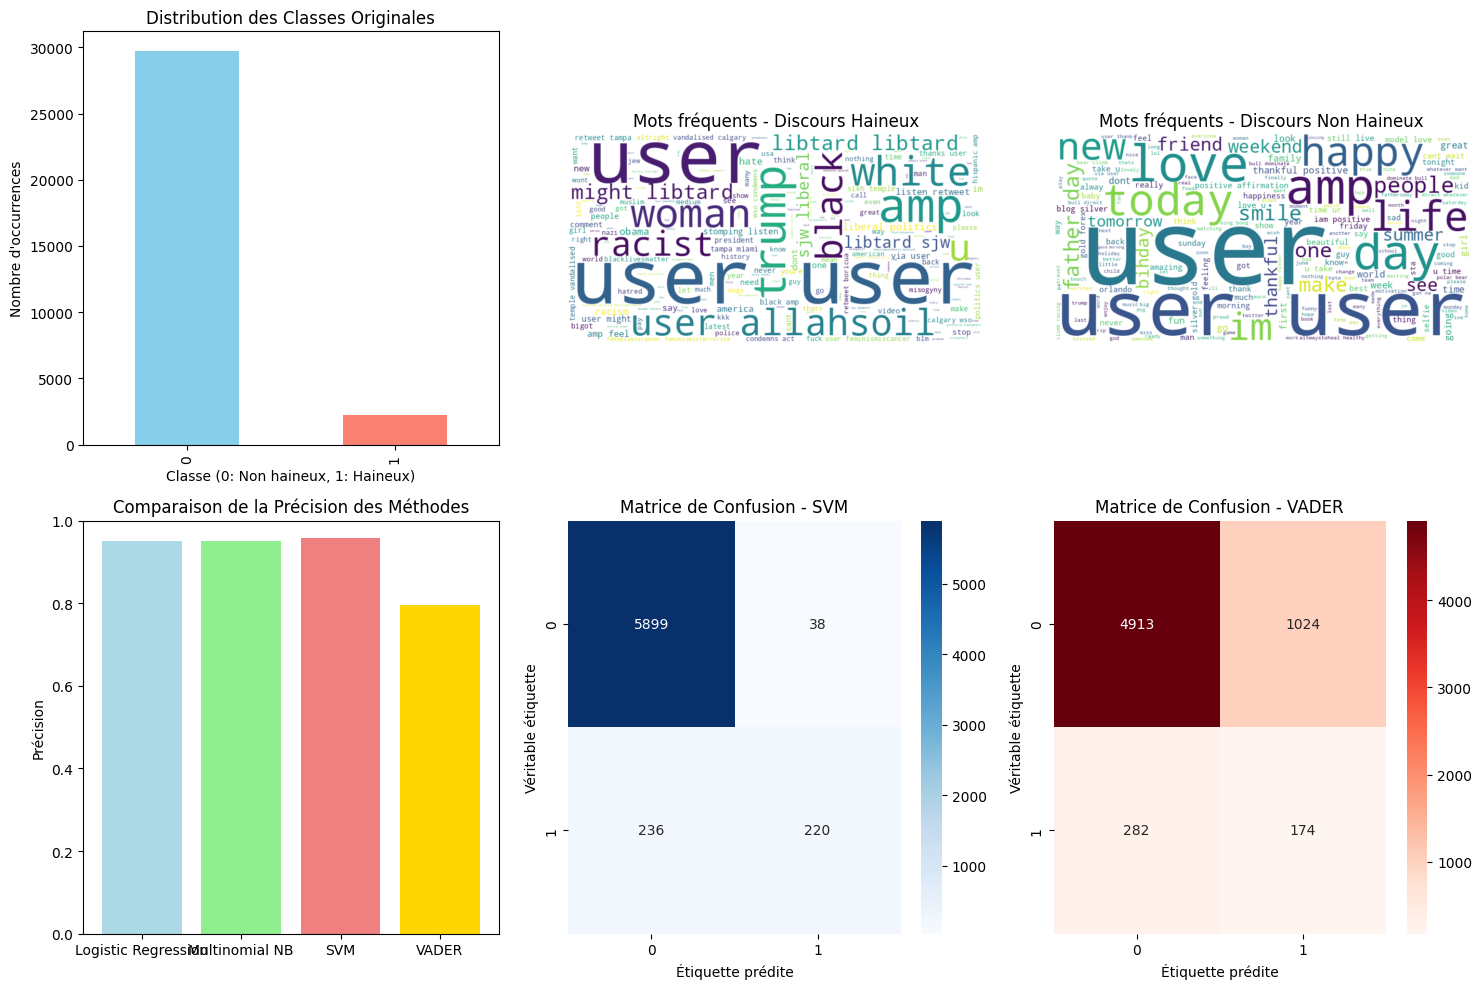


RAPPORT DE PERFORMANCE DÉTAILLÉ

Performance de VADER:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      5937
           1       0.15      0.38      0.21       456

    accuracy                           0.80      6393
   macro avg       0.55      0.60      0.55      6393
weighted avg       0.89      0.80      0.83      6393


Performance de Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.91      0.35      0.50       456

    accuracy                           0.95      6393
   macro avg       0.93      0.67      0.74      6393
weighted avg       0.95      0.95      0.94      6393


Performance de Multinomial NB:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.93      0.32      0.48       456

    accuracy                           0.95      6393
   

In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud

# Téléchargement des ressources NLTK nécessaires
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Chargement des données

df = pd.read_csv('twitter_sentiments.csv')  # Dataset avec des colonnes 'text' et 'label' (0: non haineux, 1: haineux)

# Exploration initiale des données
print("Dimensions du dataset:", df.shape)
print("\nAperçu des premières lignes:")
print(df.head())
print("\nDistribution des classes:")
print(df['label'].value_counts())

# Nettoyage et prétraitement du texte
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = nltk.word_tokenize(text)
    # Supprimer les stopwords et lemmatiser
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Appliquer le prétraitement (peut prendre du temps sur de grands datasets)
df['cleaned_text'] = df['tweet'].apply(preprocess_text)

# Méthode basée sur lexique (VADER)
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Si le score compound est négatif, considérer comme discours haineux (1)
    if scores['compound'] <= -0.05:
        return 1
    # Si le score compound est positif, considérer comme non haineux (0)
    elif scores['compound'] >= 0.05:
        return 0
    # Neutre - à classifier selon le contexte
    else:
        return 0  # On considère neutre comme non haineux pour cette analyse

# Appliquer VADER
df['vader_pred'] = df['tweet'].apply(vader_sentiment)

# Méthode basée sur machine learning
# Séparation des données
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorisation des textes
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Entraînement de plusieurs modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Multinomial NB': MultinomialNB(),
    'SVM': SVC(kernel='linear')
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    print(f"{name} Accuracy: {accuracy:.4f}")

# Évaluation de VADER
vader_accuracy = accuracy_score(y_test, df.loc[y_test.index, 'vader_pred'])
print(f"VADER Accuracy: {vader_accuracy:.4f}")

# Visualisations
plt.figure(figsize=(15, 10))

# 1. Distribution des classes
plt.subplot(2, 3, 1)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution des Classes Originales')
plt.xlabel('Classe (0: Non haineux, 1: Haineux)')
plt.ylabel('Nombre d\'occurrences')

# 2. Wordcloud pour les discours haineux
plt.subplot(2, 3, 2)
hate_speech = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hate_speech)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Mots fréquents - Discours Haineux')
plt.axis('off')

# 3. Wordcloud pour les discours non haineux
plt.subplot(2, 3, 3)
non_hate_speech = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_hate_speech)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Mots fréquents - Discours Non Haineux')
plt.axis('off')

# 4. Comparaison des précisions
plt.subplot(2, 3, 4)
methods = list(results.keys()) + ['VADER']
accuracies = [results[m]['accuracy'] for m in results] + [vader_accuracy]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar(methods, accuracies, color=colors)
plt.title('Comparaison de la Précision des Méthodes')
plt.ylabel('Précision')
plt.ylim(0, 1)

# 5. Matrice de confusion pour le meilleur modèle ML
best_ml_model = max(results, key=lambda x: results[x]['accuracy'])
y_pred_ml = results[best_ml_model]['predictions']
cm = confusion_matrix(y_test, y_pred_ml)
plt.subplot(2, 3, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de Confusion - {best_ml_model}')
plt.ylabel('Véritable étiquette')
plt.xlabel('Étiquette prédite')

# 6. Matrice de confusion pour VADER
cm_vader = confusion_matrix(y_test, df.loc[y_test.index, 'vader_pred'])
plt.subplot(2, 3, 6)
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Reds')
plt.title('Matrice de Confusion - VADER')
plt.ylabel('Véritable étiquette')
plt.xlabel('Étiquette prédite')

plt.tight_layout()
plt.savefig('sentiment_analysis_results.png')
plt.show()

# Rapport détaillé des performances
print("\n" + "="*50)
print("RAPPORT DE PERFORMANCE DÉTAILLÉ")
print("="*50)

print(f"\nPerformance de VADER:")
print(classification_report(y_test, df.loc[y_test.index, 'vader_pred']))

for name in results:
    print(f"\nPerformance de {name}:")
    print(classification_report(y_test, results[name]['predictions']))